<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_process_circle.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px;" />

<img src="https://raw.githubusercontent.com/pangeo-data/pangeo.io/refs/heads/main/public/Pangeo-assets/pangeo_logo.png"
     alt="Pangeo logo"
     style="float: center; margin-right: 10px;" />

# 2.4 Scaling with Pangeo

## Parallel computing with Dask

<div class="alert alert-info">
<i class="fa-question-circle fa" style="font-size: 22px;color:#666;"></i> <b>Overview</b>
    <br>
    <br>
    <b>Questions</b>
    <ul>
        <li>What is Dask?</li>
        <li>How can I parallelize my data analysis with Dask?</li>
    </ul>
    <b>Objectives</b>
    <ul>
        <li>Learn about Dask</li>
        <li>Learn about Dask Gateway, Dask Client, Scheduler, Workers</li>
        <li>Understand out-of-core and speed-up limitations</li>
    </ul>
</div>

## Context

We will be using [Dask](https://docs.dask.org/) with [Xarray](https://docs.xarray.dev/en/stable/) to parallelize our data analysis.  We continue to use the snow index example.  


## Parallelize with Dask

We know from the previous excerise [2.4_chunking](./chunking.ipynb) that chunking is key to analyzing large data sets. In this excersise, we will learn to parallelize our data analysis using [Dask](https://docs.dask.org/) on our chunked dataset. 

### What is [Dask](https://docs.dask.org/) ?

**Dask** scales the existing Python ecosystem: with very or no changes in your code, you can speed-up computation using Dask or process bigger than memory datasets.

- Dask is a flexible library for parallel computing in Python.
- It is widely used for handling large and complex Earth Science datasets and speed up science.
- Dask is powerful, scalable and flexible. It is the leading platform today for data analytics at scale.
- It scales natively to clusters, cloud, HPC and bridges prototyping up to production.
- The strength of Dask is that is scales and accelerates the existing Python ecosystem e.g. Numpy, Pandas and Scikit-learn with few effort from end-users.



#### How does Dask scale and accelerate your data analysis?

[Dask proposes different abstractions to distribute your computation](https://docs.dask.org/en/stable/10-minutes-to-dask.html). In this _Dask Introduction_ section, we will focus on [Dask Array](https://docs.dask.org/en/stable/array.html) which is widely used in Pangeo ecosystem as a back end of Xarray.

As shown in the [previous section](./chunking_introduction.ipynb) Dask Array is based on chunks.
Chunks of a Dask Array are well-known Numpy arrays. By transforming big datasets to Dask Array, making use of chunk, a large array is handled as many smaller Numpy ones and we can compute each of these chunks independently.

![Dask and Numpy](https://examples.dask.org/_images/dask-array-black-text.svg)

<div class="alert alert-info">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Note</b>
    <br>
    <ul>
        <li>`Xarray` uses Dask Arrays instead of Numpy when chunking is enabled, and thus all Xarray operations are performed through Dask, which enables distributed processing. </li>
    </ul>
</div>

#### How does Xarray with Dask distribute data analysis?

When we use chunks with `Xarray`, the real computation is only done when needed or asked for, usually when invoking `compute()` or `load()` functions. Dask generates a **task graph** describing the computations to be done. When using [Dask Distributed](https://distributed.dask.org/en/stable/) a **Scheduler** distributes these tasks across several **Workers**.

![Xarray with dask](../assets/dask-xarray-explained.png)

#### What is a Dask Distributed cluster ?

A Dask Distributed cluster is made of two main components:

- a Scheduler, responsible for handling computations graph and distributing tasks to Workers.
- One or several (up to 1000s) Workers, computing individual tasks and storing results and data into distributed memory (RAM and/or worker's local disk).

A user usually needs __Client__ and __Cluster__ objects as shown below to use Dask Distributed.    

![Dask Distributed Cluster](https://user-images.githubusercontent.com/306380/66413985-27111600-e9be-11e9-9995-8f418ff48f8a.png)

#### Where can we deploy a Dask distributed cluster?

[Dask distributed clusters can be deployed on your laptop or on distributed infrastructures (Cloud, HPC centers, Hadoop, etc.).](https://docs.dask.org/en/stable/deploying.html)  Dask distributed `Cluster` object is responsible of deploying and scaling a Dask Cluster on the underlying resources.

![Dask Cluster deployment](https://docs.dask.org/en/stable/_images/dask-cluster-manager.svg)

> Tip  
> A Dask `cluster` can be created on a single machine (e.g. your laptop), which means you do not need dedicated computing resources. This corresponds to **Vertical scaling** as described in [2.4 Formats and Performance](../2.4_formats_and_performance.md).
>
> However, the speedup is limited to the resources of your single machine. This is where **horizontal scaling** comes in.  By adding resources from other machines, you can expand your computing power!

### Dask distributed Client
 
The Dask distributed `Client` is what allows you to interact with Dask distributed Clusters. When using Dask distributed, you always need to create a `Client` object. Once a `Client` has been created, it will be used by default by each call to a Dask API, even if you do not explicitly use it.

No matter the Dask API (e.g. Arrays, Dataframes, Delayed, Futures, etc.) that you use, under the hood, Dask will create a Directed Acyclic Graph (DAG) of tasks by analysing the code. Client will be responsible to submit this DAG to the Scheduler along with the final result you want to compute. The Client will also gather results from the Workers, and aggregate it back in its underlying Python process.

Using `Client()` function with no argument, you will create a local Dask cluster with a number of workers and threads per worker corresponding to the number of cores in the 'local' machine. Here, during the workshop, we are running this notebook in Pangeo EOSC cloud deployment, so the 'local' machine is the jupyterlab you are using at the Cloud, and the number of cores is the number of cores on the cloud computing resources you've been given (not on your laptop).

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)   # create a local dask cluster on the local machine specifying 4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://hub.eox.at/user/6ecd4b8f-1e28-4f75-8d0a-6a67d88aa718/proxy/8787/status,
Dashboard: https://hub.eox.at/user/6ecd4b8f-1e28-4f75-8d0a-6a67d88aa718/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40899,Workers: 4
Dashboard: https://hub.eox.at/user/6ecd4b8f-1e28-4f75-8d0a-6a67d88aa718/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:40943,Total threads: 1
Dashboard: https://hub.eox.at/user/6ecd4b8f-1e28-4f75-8d0a-6a67d88aa718/proxy/43209/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:40585,


Inspecting the `Cluster Info` section above gives us information about the created cluster: we have 2 or 4 workers and the same number of threads (e.g. 1 thread per worker).

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Go further</b>
    <br>
    <ul>
        <li> You can also create a local cluster with the `LocalCluster` constructor and use `n_workers` 
        and `threads_per_worker` to manually specify the number of processes and threads you want to use. 
        For instance, we could use `n_workers=2` and `threads_per_worker=2`.  </li>
        <li> This is sometimes preferable (in terms of performance), or when you run this tutorial on your PC, 
        you can avoid dask to use all your resources you have on your PC!  </li>
    </ul>
</div>

### Dask Dashboard

Dask comes with a really handy interface: the Dask Dashboard. It is a web interface that you can open in a separate tab of your browser.

We will learn here how to use it through the [dask jupyterlab extension](https://github.com/dask/dask-labextension).  

To use Dask Dashboard through jupyterlab extension on EOX infrastructure,
you just need to click on the orange icon shown in the following figure,

![Dask.array](../assets/dashboardlink.png)

You can click several buttons marked with blue arrows in the following images, and then drag and drop them wherever you want.  

![Dask.array](../assets/dasklab.png)




![Dask.array](../assets/exampledasklab.png)

It's really helpful to understand your computation and how it's distributed.

## Dask Distributed computations on our dataset

Let's open the zarr dataset we've prepared as in [previous chunking excersise](./24_chunking.ipynb), select a single location over time, visualize the task graph generated by Dask, and observe the Dask Dashboard.



In [2]:
import xarray as xr
snow_cloud=xr.open_zarr('test.zarr')
snow_cloud

<xarray.Dataset> Size: 211MB
Dimensions:                                  (time: 3, y: 3341, x: 2630)
Coordinates: (12/35)
    band                                     <U6 24B ...
    constellation                            <U10 40B ...
    created                                  (time) <U24 288B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:boa_offset_applied           (time) bool 3B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:payload_id                   (time) <U74 888B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:s3_path                      (time) <U79 948B dask.array<chunksize=(3,), meta=np.ndarray>
    ...                                       ...
    title                                    <U30 120B ...
    updated                                  (time) <U24 288B dask.array<chunksize=(3,), meta=np.ndarray>
    view:sun_azimuth                         (time) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    view:sun_elevation                       (time) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
  * x                                        (x) float64 21kB 6.543e+05 ... 6...
  * y                                        (y) float64 27kB 5.202e+06 ... 5...
Data variables:
    data                                     (time, y, x) float64 211MB dask.array<chunksize=(1, 3341, 2630), meta=np.ndarray>
    spatial_ref                              int64 8B ...

In [3]:
snow_cloud['data'].mean(dim='x')

<xarray.DataArray 'data' (time: 3, y: 3341)> Size: 80kB
dask.array<mean_agg-aggregate, shape=(3, 3341), dtype=float64, chunksize=(1, 3341), chunktype=numpy.ndarray>
Coordinates: (12/34)
    band                                     <U6 24B ...
    constellation                            <U10 40B ...
    created                                  (time) <U24 288B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:boa_offset_applied           (time) bool 3B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:payload_id                   (time) <U74 888B dask.array<chunksize=(3,), meta=np.ndarray>
    earthsearch:s3_path                      (time) <U79 948B dask.array<chunksize=(3,), meta=np.ndarray>
    ...                                       ...
  * time                                     (time) datetime64[ns] 24B 2019-0...
    title                                    <U30 120B ...
    updated                                  (time) <U24 288B dask.array<chunksize=(3,), meta=np.ndarray>
    view:sun_azimuth                         (time) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    view:sun_elevation                       (time) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
  * y                                        (y) float64 27kB 5.202e+06 ... 5...

## Did you notice something on the Dask Dashboard when running the two previous cells?

We didn't 'compute' anything. We just built a Dask task graph with it's size indicated as count above, but did not ask Dask to return a result.

Here, you can check 'Dask graph' with how many layers of graph you have, to estimate the complexity of your computation.

It is indicated that you have '7 graph'.  this can be optimized with following step

Let's try to plot the dask graph before computation and understand what dask workers will do to compute the value we asked for.

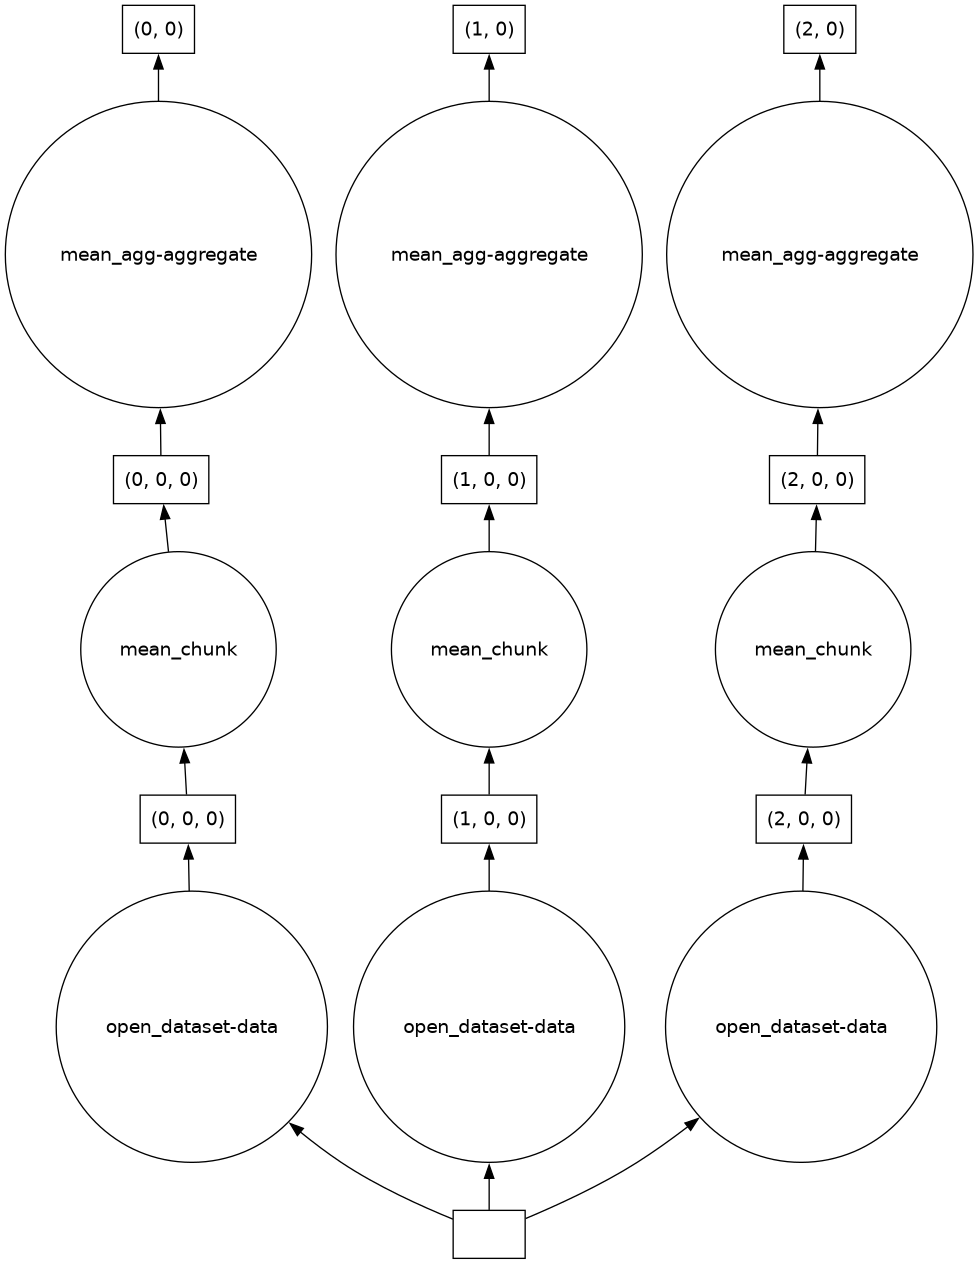

In [4]:
snow_cloud['data'].mean(dim='x').data.visualize()

## Lets try to mean the time dimention and see how it differs?

In [5]:
snow_cloud['data'].mean(dim='time')

<xarray.DataArray 'data' (y: 3341, x: 2630)> Size: 70MB
dask.array<mean_agg-aggregate, shape=(3341, 2630), dtype=float64, chunksize=(3341, 2630), chunktype=numpy.ndarray>
Coordinates: (12/13)
    band                                     <U6 24B ...
    constellation                            <U10 40B ...
    epsg                                     int64 8B ...
    instruments                              <U3 12B ...
    mgrs:latitude_band                       <U1 4B ...
    mgrs:utm_zone                            int64 8B ...
    ...                                       ...
    s2:datatake_type                         <U8 32B ...
    s2:product_type                          <U7 28B ...
    s2:saturated_defective_pixel_percentage  int64 8B ...
    title                                    <U30 120B ...
  * x                                        (x) float64 21kB 6.543e+05 ... 6...
  * y                                        (y) float64 27kB 5.202e+06 ... 5...

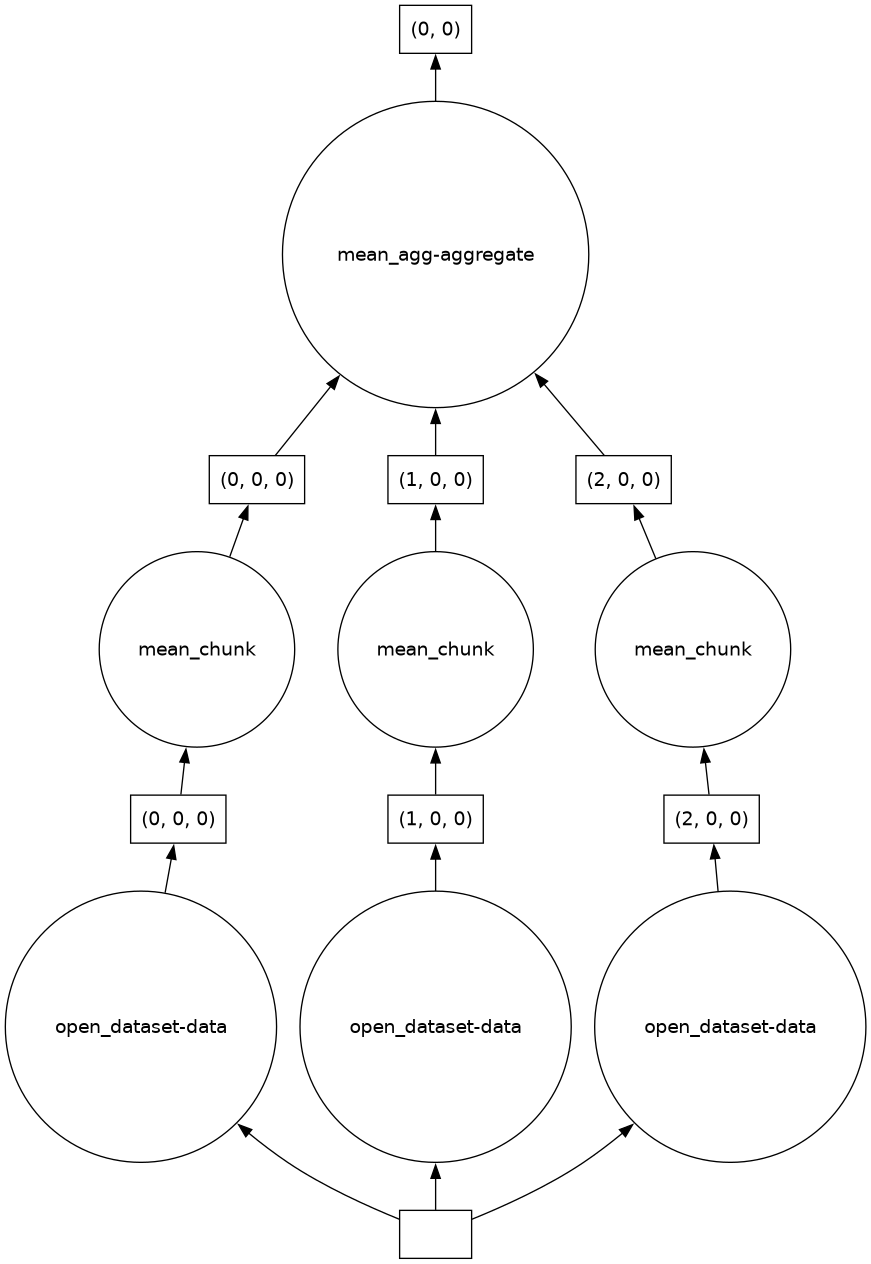

In [6]:
snow_cloud['data'].mean(dim='time').data.visualize()

### Lets Compute on the dask workers

In [7]:
snow_cloud['data'].mean(dim='time').compute()

<xarray.DataArray 'data' (y: 3341, x: 2630)> Size: 70MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates: (12/13)
    band                                     <U3 12B 'scl'
    constellation                            <U10 40B 'sentinel-2'
    epsg                                     int64 8B 32632
    instruments                              <U3 12B 'msi'
    mgrs:latitude_band                       <U1 4B 'T'
    mgrs:utm_zone                            int64 8B 32
    ...                                       ...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    s2:product_type                          <U7 28B 'S2MSI2A'
    s2:saturated_defective_pixel_percentage  int64 8B 0
    title                                    <U30 120B 'Scene classification ...
  * x                                        (x) float64 21kB 6.543e+05 ... 6...
  * y                                        (y) float64 27kB 5.202e+06 ... 5...

Calling compute on our Xarray object triggered the execution on Dask Cluster side. 

You should be able to see how Dask is working on Dask Dashboard. 

### Lets try bigger computation.
We will re-use the procedure we've learnd in the previous chunking notebook.


In [8]:
### Load data using stackstac (with specific chunk) 
import stackstac
import pystac_client
import geopandas as gpd
from shapely.geometry import mapping
import numpy as np
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", RuntimeWarning)

aoi = gpd.read_file("../assets/catchment_outline.geojson", crs="EPGS:4326")
aoi_geojson = mapping(aoi.iloc[0].geometry)
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)
items = catalog.search(
    intersects=aoi_geojson,
    collections=["sentinel-2-l2a"],
    datetime="2019-02-01/2019-03-28"
).item_collection()
ds = stackstac.stack(items
                                ,assets=['green','swir16','scl']
                               ,chunksize=( 1, 3, 1024,1024)
)
ds

<xarray.DataArray 'stackstac-f8a730b38e0478cef759add706a91ca3' (time: 55,
                                                                band: 3,
                                                                y: 20982,
                                                                x: 10980)> Size: 304GB
dask.array<fetch_raster_window, shape=(55, 3, 20982, 10980), dtype=float64, chunksize=(1, 3, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 440B 2019-...
    id                                       (time) <U24 5kB 'S2B_32TPT_20190...
  * band                                     (band) <U6 72B 'green' ... 'scl'
  * x                                        (x) float64 88kB 6e+05 ... 7.098...
  * y                                        (y) float64 168kB 5.3e+06 ... 5....
    s2:reflectance_conversion_factor         (time) float64 440B 1.031 ... 1.006
    ...                                       ...
    title                                    (band) <U30 360B 'Green (band 3)...
    raster:bands                             (band) object 24B None ... [{'no...
    common_name                              (band) object 24B 'green' ... None
    center_wavelength                        (band) object 24B 0.56 1.61 None
    full_width_half_max                      (band) object 24B 0.045 0.143 None
    epsg                                     int64 8B 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(600000.0, 5090220.0, 709800.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 600000.00|\n| 0.00,-10.00, 5300040.00|\n| 0.0...
    resolution:  10.0

By inspecting any of the variables on the representation above, you'll see that the data array represents __above 280GiB of data__, so much more than the availabe memory on this notebook server, the Dask Local Cluster we created above. But thanks to chunking, we can still analyze it!


In [9]:
## Coomputing Snow index
green = ds.sel(band='green')
swir = ds.sel(band='swir16')
scl = ds.sel(band='scl')
ndsi = (green - swir) / (green + swir)
snow = xr.where((ndsi > 0.42) & ~np.isnan(ndsi), 1, ndsi)
snowmap = xr.where((snow <= 0.42) & ~np.isnan(snow), 0, snow)
mask = np.logical_not(scl.isin([8, 9, 3])) 
snow_cloud = xr.where(mask, snowmap, 2)
## Clip the data
aoi_utm32 = aoi.to_crs(epsg=32632)
geom_utm32 = aoi_utm32.iloc[0]['geometry']
snow_cloud.rio.write_crs("EPSG:32632", inplace=True)
snow_cloud.rio.set_nodata(np.nan, inplace=True)
snow_cloud = snow_cloud.rio.clip([geom_utm32])
snow_cloud=snow_cloud.groupby(snow_cloud.time.dt.floor('D')).max(skipna=True)
snow_cloud=snow_cloud.chunk(chunks = {'x':'auto', 'y': 'auto'})
snow_cloud

<xarray.DataArray 'stackstac-f8a730b38e0478cef759add706a91ca3' (floor: 23,
                                                                y: 3341, x: 2630)> Size: 2GB
dask.array<rechunk-merge, shape=(23, 3341, 2630), dtype=float64, chunksize=(1, 3341, 2630), chunktype=numpy.ndarray>
Coordinates: (12/19)
    band                                     <U6 24B 'scl'
  * x                                        (x) float64 21kB 6.543e+05 ... 6...
  * y                                        (y) float64 27kB 5.202e+06 ... 5...
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    constellation                            <U10 40B 'sentinel-2'
    s2:saturated_defective_pixel_percentage  int64 8B 0
    ...                                       ...
    common_name                              object 8B None
    center_wavelength                        object 8B None
    full_width_half_max                      object 8B None
    epsg                                     int64 8B 32632
    spatial_ref                              int64 8B 0
  * floor                                    (floor) datetime64[ns] 184B 2019...
Attributes:
    _FillValue:  nan

In [ ]:
snow_cloud.to_zarr('snow_cloud.zarr',mode='w')

### Close client to terminate local dask cluster

The `Client` and associated `LocalCluster` object will be automatically closed when your Python session ends. When using Jupyter notebooks, we recommend to close it explicitely whenever you are done with your local Dask cluster.

In [ ]:
client.close()

## Conclusion. 

For this exercise, we created a Dask cluster on a single machine, which is equivalent to vertical scaling as described in 2.4 Formats and performance. 

However, the speedup is limited to the resources of your single machine. This is where horizontal scaling comes in. By adding resources from other machines, you can expand your computing power! In the case of dask, you can use the [Dask Gatway](https://gateway.dask.org/#dask-gateway).   
The Pangeo community hosts tutorials using [Pangeo@EOSC]('https://pangeo-eosc.vm.fedcloud.eu/hub/'). With the Pangeo EOSC deployment, you can learn how to use Dask Gateway to manage Dask clusters over Kubernetes, allowing us to run our data analysis in parallel, e.g. distribute tasks across multiple workers.
If you are a user of HPC center, you can also consider using [Dask-jobque](https://docs.dask.org/en/stable/deploying-hpc.html#high-performance-computers) or Dask HPC for this.  